In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature
import pickle
from sklearn.preprocessing import StandardScaler
import random
import pickle

In [2]:
from cars_detector.utils  import read_test_frame, read_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features, compute_colors_features
from cars_detector.makebox import non_max_suppression, box_otsu
from cars_detector.splitpictures import pyramid

In [3]:
df_ground_truth = pd.read_csv('train.csv')

## Sampling of positive and negative examples

In [4]:
if os.path.isfile("data/pos_neg_samples/positive_samples.pkl") and os.path.isfile("data/pos_neg_samples/negative_samples.pkl"):
    print('load data')
    total_positive_samples = pickle.load(open('data/pos_neg_samples/positive_samples.pkl', 'rb'))
    total_negative_samples = pickle.load(open('data/pos_neg_samples/negative_samples.pkl', 'rb'))

else:
    total_positive_samples, total_negative_samples = sampling(df_ground_truth)
    pickle.dump(total_negative_samples,open('data/pos_neg_samples/negative_samples.pkl', 'wb'))
    pickle.dump(total_positive_samples,open('data/pos_neg_samples/positive_samples.pkl', 'wb'))
    


load data


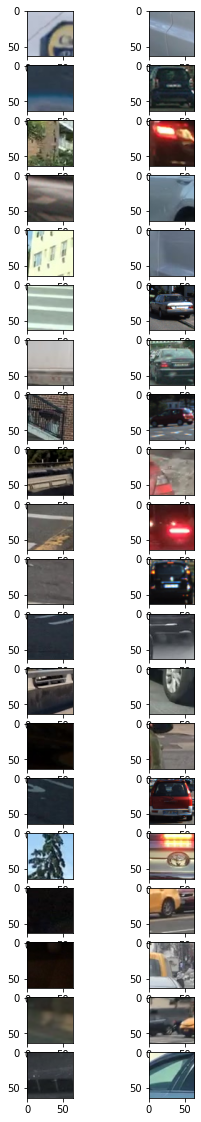

In [5]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)

fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]

        ax[i][j].imshow(img)

## Data Augmentation

In [6]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.1
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

for img in tqdm(total_negative_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_negative_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/26376 [00:00<?, ?it/s]/home/33631/cars_detection/venv/lib/python3.7/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 44840/44840 [00:01<00:00, 32576.59it/s]


In [7]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 29089
number of negative samples: 49327


## Features computation

In [8]:
if os.path.isfile("data/features/positive_features.pkl") and os.path.isfile("data/features/negative_features.pkl"):
    print('load data')
    positive_features = pickle.load(open("data/features/positive_features.pkl", 'rb'))
    negative_features = pickle.load(open("data/features/negative_features.pkl", 'rb'))
else:
    print('compute features')
    positive_features = []
    for img in tqdm(total_positive_samples, position = 0):
        feat = compute_features(img)
        positive_features.append(feat)
    pickle.dump(positive_features,open("data/features/positive_features.pkl", 'wb'))

    negative_features = []
    for img in tqdm(total_negative_samples, position = 0):
        feat = compute_features(img)
        negative_features.append(feat)
    pickle.dump(positive_features,open("data/features/negative_features.pkl", 'wb'))

load data


In [9]:
from sklearn.model_selection import train_test_split
import gc
X = np.concatenate((positive_features,negative_features), axis = 0)
y = np.array([1 for i in range(len(positive_features))]+[0 for i in range(len(negative_features))])

del positive_features
del negative_features
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(np.float32(X_train))
X_test = scaler.transform(np.float32(X_test))

In [10]:
del X
del y
gc.collect()

21

In [11]:
# creata weight matrix
weight_ratio = float(len(y_train[y_train == 0]))/float(len(y_train))
w_array = np.zeros(y_train.shape[0])
w_array[y_train==1] = weight_ratio
w_array[y_train==0] = 1- weight_ratio

In [18]:
eval_set = [(X_test, y_test)]
if os.path.isfile('data/models/XGB.json'):
    print('load model')
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.load_model("data/models/XGB.json")
else:
    clf = XGBClassifier(early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set)
    clf.fit(X_train, y_train, sample_weight=w_array)
    clf.save_model("data/models/XGB.json")



y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")


/home/33631/cars_detection/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:53] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy: 0.10575843909177242


/home/33631/cars_detection/venv/lib/python3.7/site-packages/xgboost/sklearn.py:585: UserWarning: kwargs is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


## Pyramid Window Sliding

In [13]:
def window_sliding(img, minSize=(64, 64), scale_step = 1.5):
    bboxes = []
    pred_array = np.zeros((img.shape[0], img.shape[1]), dtype = float)
            
    
    window = minSize[0]
    step = 40

    for i,test_img in enumerate(pyramid(img, scale=scale_step, minSize=minSize)):
        x_size = test_img.shape[1]
        y_size = test_img.shape[0]
        scale = scale_step**i
        for xb in range(0, x_size-window, step):
            for yb in range(0, y_size-window, step):
                
                xleft = np.int32(xb*scale)
                ytop = np.int32(yb*scale)

                crop = test_img[ytop:ytop+window,xleft:xleft+window,:]
                
                if crop.shape[0] == window and crop.shape[1] == window:
                    # Compute individual channel HOG features for the entire image
                    hog1 = feature.hog(crop[:,:,0], orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), feature_vector=False).ravel()
                    hog2 = feature.hog(crop[:,:,1], orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), feature_vector=False).ravel()
                    hog3 = feature.hog(crop[:,:,2], orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), feature_vector=False).ravel()
    
                    hog_features = np.hstack((hog1, hog2, hog3))
                    color_features = compute_colors_features(crop)
                    features = np.concatenate((hog_features, color_features))

                    # Scale features and make a prediction
                    test_features = scaler.transform([features])
                    test_prediction = clf.predict(test_features)

                    if test_prediction == 1:
                        xbox_left = np.int32(xleft*scale)
                        ytop_draw = np.int32(ytop*scale)
                        win_draw = np.int32(window*scale)
                        # do not consider front of the car
                        if ytop_draw+win_draw <= 500 and 150 <= ytop_draw:
                            box = [xbox_left,ytop_draw, win_draw,win_draw] 
                            bboxes.append(box)
                            pred_array[ytop_draw:ytop_draw+win_draw, xbox_left:xbox_left+win_draw] += 1

    return(bboxes, pred_array)

In [14]:
def filter_boxes(bboxes,pred_array):
    boxes_to_keep = []
    means_list = []

    bin =  np.bincount(pred_array.ravel().astype('int'))
    threshold = np.argmax(bin/np.cumsum(bin) < 0.02)

    for box in bboxes:
        if len(box) > 0:
            try:
                mean_pred = np.mean(pred_array[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])
                means_list.append(mean_pred)
                if mean_pred > threshold:
                    boxes_to_keep.append(box)
            except:
                continue
    return(boxes_to_keep)

In [15]:
def non_max_suppression(boxes, overlapThresh = 0.4):
    # Return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = x1+boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = y1+boxes[:, 3]  # y coordinate of the bottom-right corner
    # Compute the area of the bounding boxes and sort the bounding
    # Boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We add 1, because the pixel at the start as well as at the end counts
    # The indices of all boxes at start. We will redundant indices one by one.
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        # Create temporary indices  
        temp_indices = indices[indices!=i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[0]+box[2], boxes[temp_indices,0]+boxes[temp_indices,2])
        yy2 = np.minimum(box[1]+box[3], boxes[temp_indices,1]+boxes[temp_indices,3])
        # Find out the width and the height of the intersection box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index  
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    #return only the boxes at the remaining indices

    boxes = boxes[indices].astype(int)
    new_boxes = []
    for box in boxes:
        dx = box[2]
        dy = box[3]
        if dx >= 100 and dy >= 100:
            new_boxes.append(box)
    return new_boxes

In [16]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [24]:
from skimage.io import imread
import copy 

images_list = os.listdir('test/')
submission_df = pd.read_csv('sample_submission.csv')
submission_df = submission_df.drop(index = [0])
for img_path in tqdm(images_list, position=0):
    img = imread('./test/'+img_path)

    (bboxes, pred_array) = window_sliding(img)
    # non max suppresion
    new_boxes = box_otsu(pred_array>1)

    new_boxes = non_max_suppression(np.array(new_boxes))

    predictions = np.array(new_boxes).ravel()

    final_pred = ' '.join(predictions.astype(str))

    line_to_add = pd.DataFrame([['test/'+img_path, final_pred]], columns = submission_df.columns)
    submission_df  = pd.concat([submission_df, line_to_add], axis = 0)

verif_df = copy.deepcopy(submission_df)
# pre saving in order not to loose everything    
submission_df.to_csv('final_predictions.csv', index=False)
# convert prediction to the right format
preds = []
for i in range(submission_df.shape[0]):

    bbs = list(map(int, submission_df.iloc[i].Predicted.split(" ")))
    bbs = np.array_split(bbs, len(bbs) / 4)

    mask = bounding_boxes_to_mask(bbs, 720, 1280)
    pred = run_length_encoding(mask)
    preds.append(pred)

submission_df.Predicted = preds

submission_df.to_csv('final_predictions.csv', index=False)

100%|██████████| 2/2 [00:23<00:00, 11.96s/it]


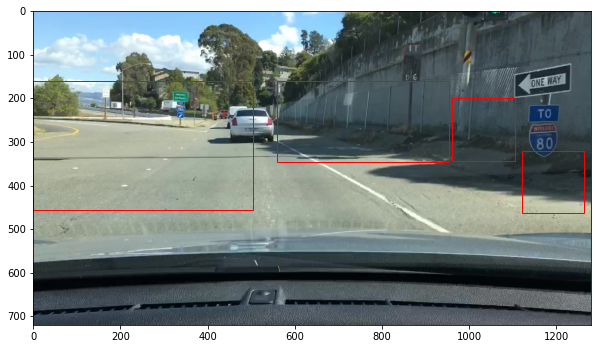

In [23]:
images_list = os.listdir('test/')


img = imread('./test/'+images_list[20])

(bboxes, pred_array) = window_sliding(img)
# filter boxes
#bboxes = filter_boxes(bboxes,pred_array)

# non max suppresion
new_boxes = box_otsu(pred_array>1)

new_boxes = non_max_suppression(np.array(new_boxes))

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in new_boxes:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img)